In [21]:
from IPython.core.interactiveshell import InteractiveShell
import warnings 
import pickle 
InteractiveShell.ast_node_interactive = "all"
warnings.filterwarnings("ignore")

import pandas as pd
import torch                                      # root package
from torch.utils.data import Dataset, DataLoader  # data 
import torch.autograd as autograd                 # computation graph
from torch import Tensor                          # tensor node in the computation graph
import torch.nn as nn                             # neural networks
import torch.nn.functional as F                   # layers, activations and more
import torch.optim as optim  
import matplotlib.pyplot as plt
import torchaudio                                 # audio processing

In [14]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("*"*10)
        print("Source:", src)
        print("*"*10)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")



def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].set_xlabel("Time [s]")
        axes[c].set_ylabel("Amplitude")
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
        
    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    num_channels, _ = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate, sides="onesided")
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        axes[c].set_xlabel("Time [s]")
        axes[c].set_ylabel("Frequency [Hz]")
    figure.suptitle(title)
    plt.show(block=False)

metadata:  AudioMetaData(sample_rate=32000, num_frames=4654336, num_channels=1, bits_per_sample=0, encoding=MP3)
Sample Rate: 32000
Shape: (1, 4652928)
Dtype: torch.float32
 - Max:      0.560
 - Min:     -0.583
 - Mean:     0.000
 - Std Dev:  0.033

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



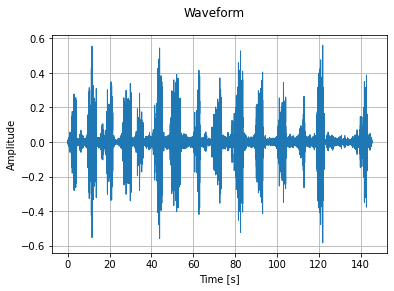

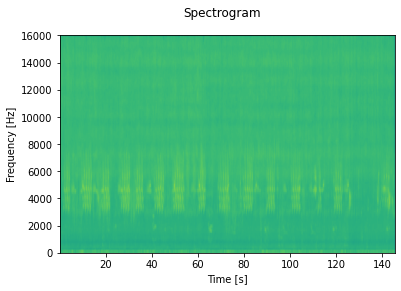

In [22]:
SAMPLE_MP3_PATH = ("/home/akinwilson/Projects/bird-sound-classifier/data/birds/Phylloscopuscollybita/Poland"
"/Phylloscopuscollybita325319.mp3")
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print("metadata: ", metadata)


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_sample(SAMPLE_WAV_PATH, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)


def get_dataset(name):
    df = pd.DataFrame.from_dict(pickle.load(open(f"./data/{name}.p", "rb")).items())
    return df 


SAMPLE_RATE = 32000
waveform, sample_rate = get_sample(SAMPLE_MP3_PATH, resample=SAMPLE_RATE)
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

5.0